In [1]:
import copy
import numpy as np
from persor import BVHparser
from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation

In [2]:
def get_joint_coords(skeleton, joint, coords):
    offset = skeleton[joint]["offset"]
    parent_joint = skeleton[joint]["joint"]
    child_joints = skeleton[joint]["children"]

    if parent_joint == None:
        return

    parent_coord = coords[parent_joint]["coord"]

    current_coord = [
        parent_coord[0] + offset[0],
        parent_coord[1] + offset[1],
        parent_coord[2] + offset[2],
    ]
    coords[joint] = {"coord": current_coord, "parent": parent_joint}

    for child in child_joints:
        get_joint_coords(skeleton, child, coords)


def skelton2coords(skeleton):
    coords = {"root": {"coord": skeleton["root"]["offset"], "parent": None}}

    child_joints = skeleton["root"]["children"]
    for child in child_joints:
        get_joint_coords(skeleton, child, coords)

    get_joint_coords(skeleton, "root", coords)

    return coords


def get_rotate_vec(frame, path):
    x_rotate = sum([frame[f"{joint}_Xrotation"] for joint in path])
    y_rotate = sum([frame[f"{joint}_Yrotation"] for joint in path])
    z_rotate = sum([frame[f"{joint}_Zrotation"] for joint in path])
    x_position = frame[f"{path[0]}_Xposition"]
    y_position = frame[f"{path[0]}_Yposition"]
    z_position = frame[f"{path[0]}_Zposition"]

    R_x = Rotation.from_euler("x", x_rotate, degrees=True).as_matrix()
    R_y = Rotation.from_euler("y", y_rotate, degrees=True).as_matrix()
    R_z = Rotation.from_euler("z", z_rotate, degrees=True).as_matrix()

    return R_y @ R_x @ R_z @ np.array([x_position, y_position, z_position])


def get_path2root(skeleton, joint):
    path = []
    while True:
        path.append(joint)
        joint = skeleton[joint]["joint"]
        if joint == None:
            break
    return path


def rotated_skeleton(skeleton, frame):
    skeleton_copy = copy.deepcopy(skeleton)

    for joint in skeleton.keys():
        if joint.startswith("_"):
            continue

        path = get_path2root(skeleton, joint)
        skeleton_copy[joint]["offset"] = get_rotate_vec(frame, path)

    return skeleton_copy


def convert2coordDict(df, skeleton):
    df = df.copy()
    data = []
    for i in range(len(df)):
        skeleton_rotated = rotated_skeleton(skeleton, df.iloc[i])
        coords = skelton2coords(skeleton_rotated)
        data.append(coords)

    return np.array(data)


def coord_dict2coords_array(coords_dict):
    return np.array(
        [[data["coord"] for joint, data in coords.items()] for coords in coords_dict]
    )


def get_splited_data(bvhp, window_size, stride, start=0, label=0):
    df = bvhp.get_motion_df()
    skeleton = bvhp.get_skeleton()
    coord_data = coord_dict2coords_array(convert2coordDict(df, skeleton))

    data = np.array(
        [
            coord_data[i : i + window_size]
            for i in range(start, len(df) - window_size, stride)
        ]
    ).transpose(0, 3, 1, 2)
    labels = [label] * len(data)

    return data, labels

In [3]:
bvhp = BVHparser("./data/iroiro.bvh")
df = bvhp.get_motion_df()
skeleton = bvhp.get_skeleton()
coords = convert2coordDict(df, skeleton)

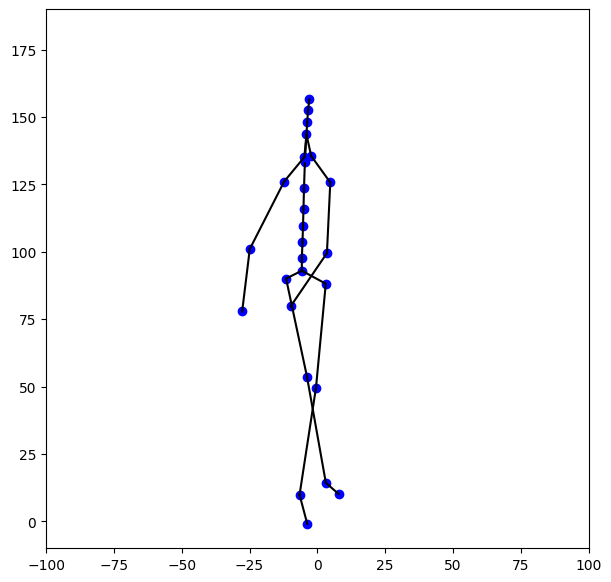

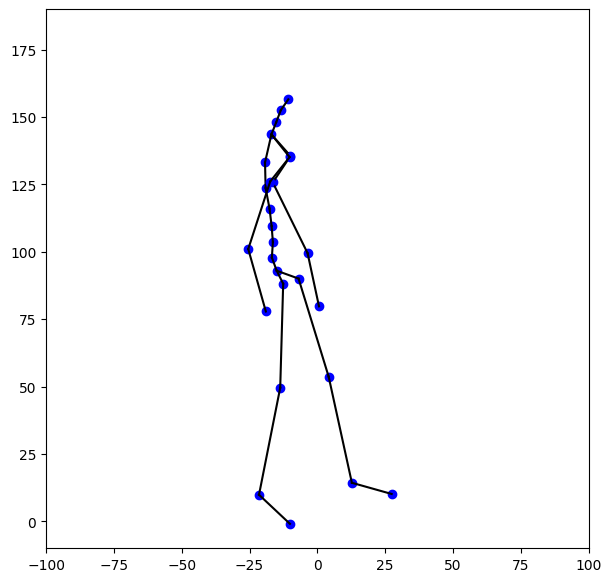

In [4]:
df = bvhp.get_motion_df()
skeleton = bvhp.get_skeleton()
frame = df.iloc[380]

skeleton_rotated = rotated_skeleton(skeleton, frame)
frame_coords = skelton2coords(skeleton_rotated)

plt.figure(figsize=(7, 7))
for c in frame_coords.values():
    plt.plot(c["coord"][0], c["coord"][1], marker="o", color="blue")
    parent = c["parent"]

    if parent == None:
        continue

    parent_coord = frame_coords[parent]["coord"]
    plt.plot(
        [c["coord"][0], parent_coord[0]],
        [c["coord"][1], parent_coord[1]],
        color="black",
    )

plt.xlim(-100, 100)
plt.ylim(-10, 190)
plt.show()

plt.figure(figsize=(7, 7))
for c in frame_coords.values():
    plt.plot(c["coord"][2], c["coord"][1], marker="o", color="blue")
    parent = c["parent"]

    if parent == None:
        continue

    parent_coord = frame_coords[parent]["coord"]
    plt.plot(
        [c["coord"][2], parent_coord[2]],
        [c["coord"][1], parent_coord[1]],
        color="black",
    )

plt.xlim(-100, 100)
plt.ylim(-10, 190)
plt.show()

In [5]:
fig = plt.figure(figsize=(5, 5))
plt.xlim(-100, 100)
plt.ylim(-10, 190)

frames = []
for coord in coords[0:-1:10]:
    frame = []
    for c in coord.values():
        frame.append(
            plt.plot(c["coord"][0], c["coord"][1], marker="o", color="blue")[0]
        )
        parent = c["parent"]

        if parent == None:
            continue

        parent_coord = coord[parent]["coord"]
        frame.append(
            plt.plot(
                [c["coord"][0], parent_coord[0]],
                [c["coord"][1], parent_coord[1]],
                color="blue",
            )[0]
        )

    frames.append(frame)

ani = ArtistAnimation(fig, frames, interval=1)

ani.save(f"animation-0-1.gif", writer="pillow")
plt.close()

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.xlim(-100, 100)
plt.ylim(-10, 190)

frames = []
for coord in coords[0:-1:10]:
    frame = []
    for c in coord.values():
        frame.append(
            plt.plot(c["coord"][2], c["coord"][1], marker="o", color="blue")[0]
        )
        parent = c["parent"]

        if parent == None:
            continue

        parent_coord = coord[parent]["coord"]
        frame.append(
            plt.plot(
                [c["coord"][2], parent_coord[2]],
                [c["coord"][1], parent_coord[1]],
                color="blue",
            )[0]
        )

    frames.append(frame)

ani = ArtistAnimation(fig, frames, interval=1)

ani.save(f"animation-1-2.gif", writer="pillow")
plt.close()